In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

plt.style.use('ggplot')

In [2]:
file_path = 'Steel_industry_data.csv'  # Replace with your file path
steel_data = pd.read_csv(file_path)

In [3]:
# Preprocessing
steel_data['date'] = pd.to_datetime(steel_data['date'])
steel_data['hour'] = steel_data['date'].dt.hour
steel_data['day'] = steel_data['date'].dt.day
steel_data['month'] = steel_data['date'].dt.month
steel_data['year'] = steel_data['date'].dt.year
steel_data['dayofweek'] = steel_data['date'].dt.dayofweek
steel_data.drop('date', axis=1, inplace=True)
categorical_columns = ['WeekStatus', 'Day_of_week', 'Load_Type']
steel_data_encoded = pd.get_dummies(steel_data, columns=categorical_columns, drop_first=True)

In [5]:
steel_data_encoded.head()


,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,hour,day,month,...,dayofweek,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Maximum_Load,Load_Type_Medium_Load
0,3.17,2.95,0.0,0.0,73.21,100.0,900,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,0,1,1,...,0,0,1,0,0,0,0,0,0,0
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,0,1,1,...,0,0,1,0,0,0,0,0,0,0
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,1,1,1,...,0,0,1,0,0,0,0,0,0,0
4,3.82,4.50,0.0,0.0,64.72,100.0,4500,1,1,1,...,0,0,1,0,0,0,0,0,0,0


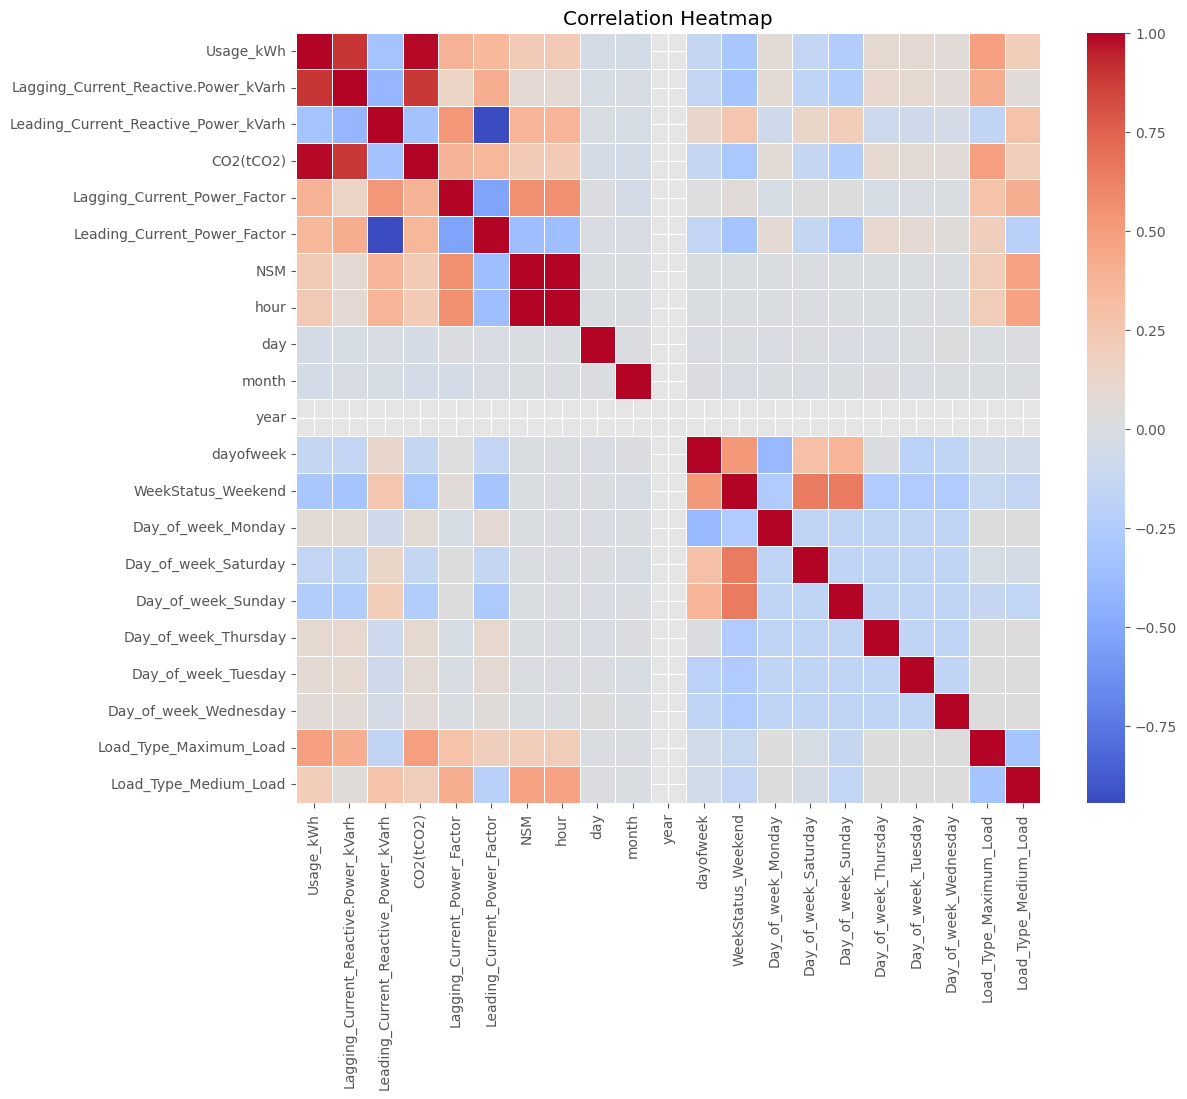

In [4]:
# Time-based features have been created from the 'date' column.
corr_matrix = steel_data_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

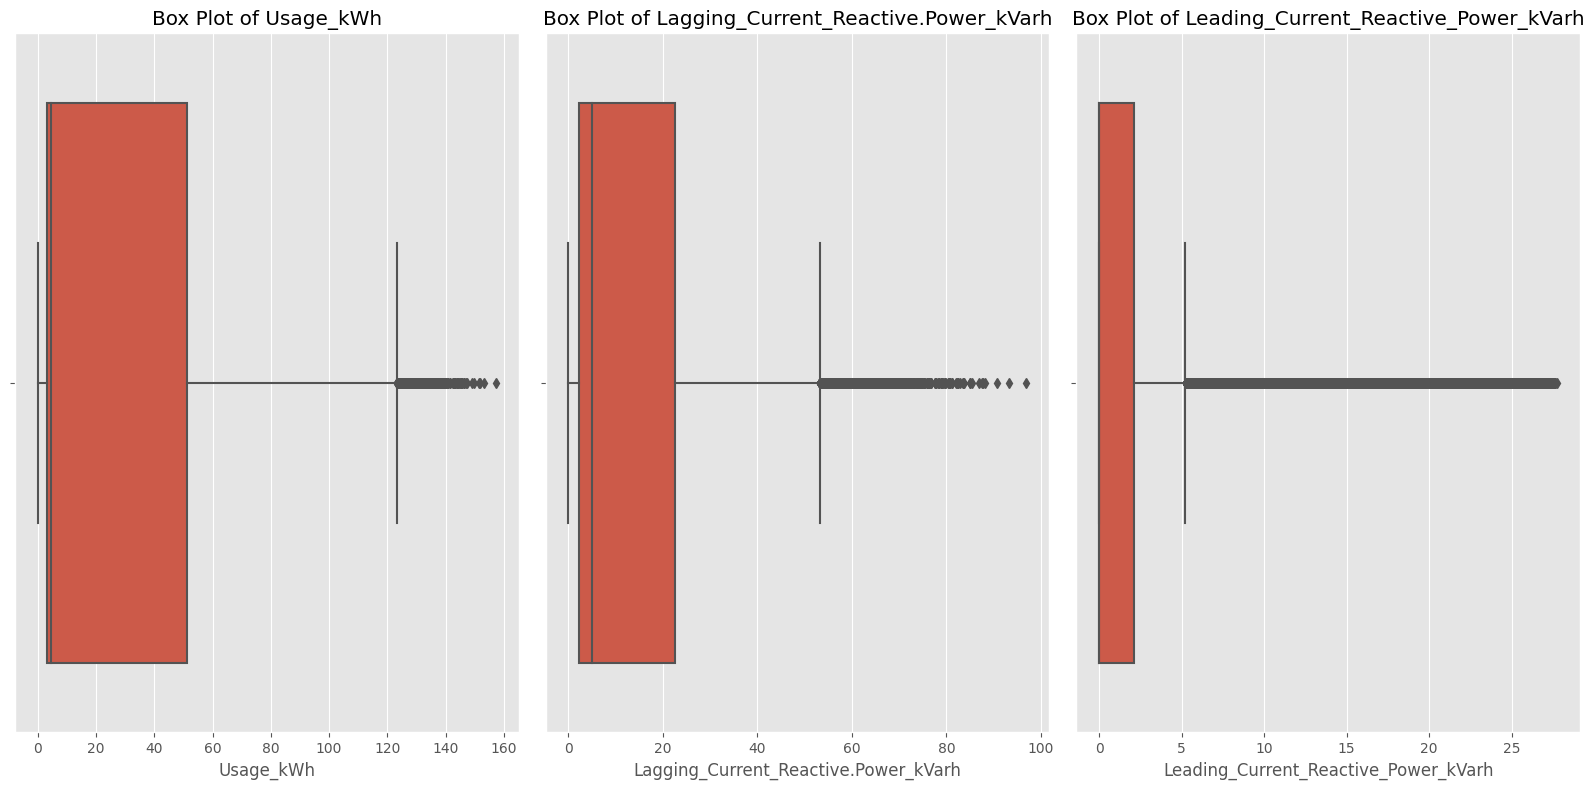

In [6]:
continuous_features = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh']

# Create a single figure with subplots
plt.figure(figsize=(16, 8))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(1, 3, i)  # 1 row, 3 columns, i-th subplot
    sns.boxplot(x=steel_data_encoded[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()  # Adjusts subplot spacing for a better layout
plt.show()

In [7]:
# Split the data into features and target
X = steel_data_encoded.drop('Usage_kWh', axis=1)
y = steel_data_encoded['Usage_kWh']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Model1: XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(random_state=42)
xgb_regressor.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
parameters = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(xgb_regressor, parameters, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


In [11]:
best_parameters

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300}

In [12]:
y_pred = best_model.predict(X_test_scaled)

In [13]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve
# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores = -cv_scores  # Negate to get the positive MAE values
cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)
print(cv_scores,cv_scores_mean,cv_scores_std)

[0.44041263 0.46733301 0.41089743 0.45184736 0.43945617] 0.4419893218036307 0.018520757142462027


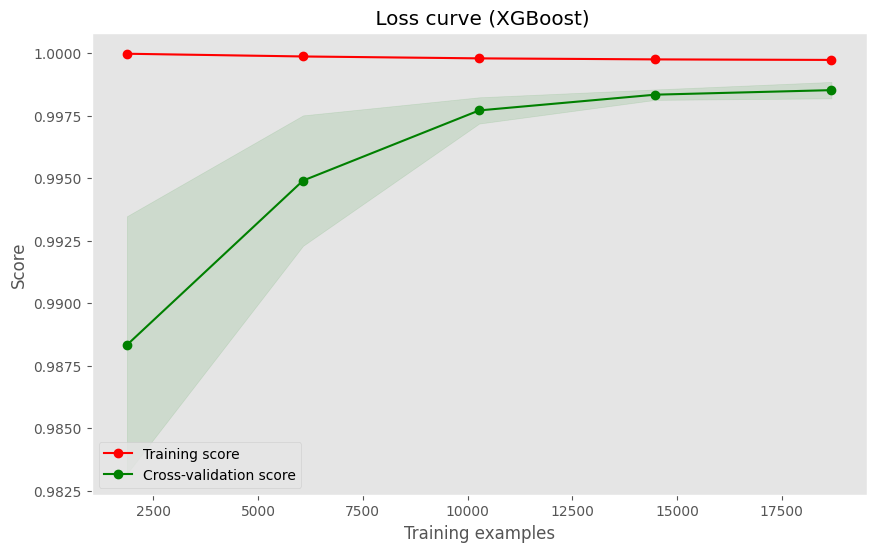

In [14]:
# Visualization of Learning Curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(xgb_regressor, " Loss curve (XGBoost)", X_train_scaled, y_train, cv=3)
plt.show()

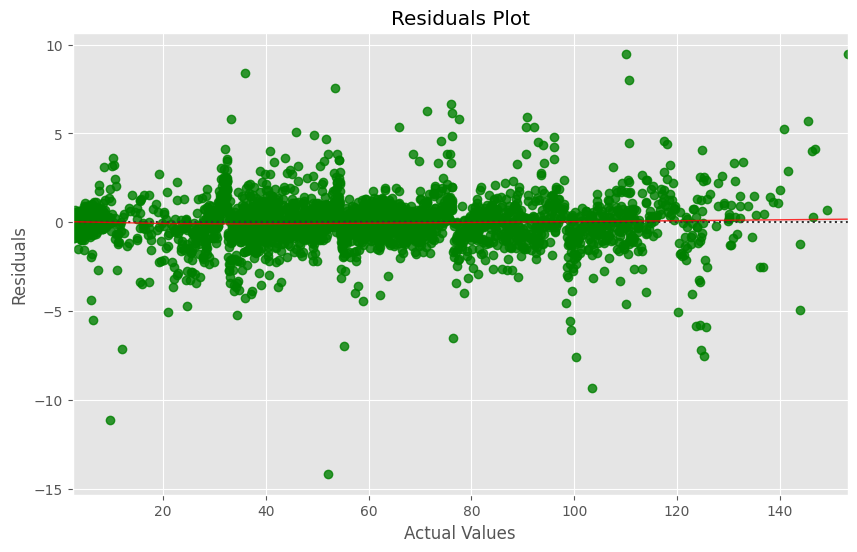

In [15]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=residuals, lowess=True, color="g", line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

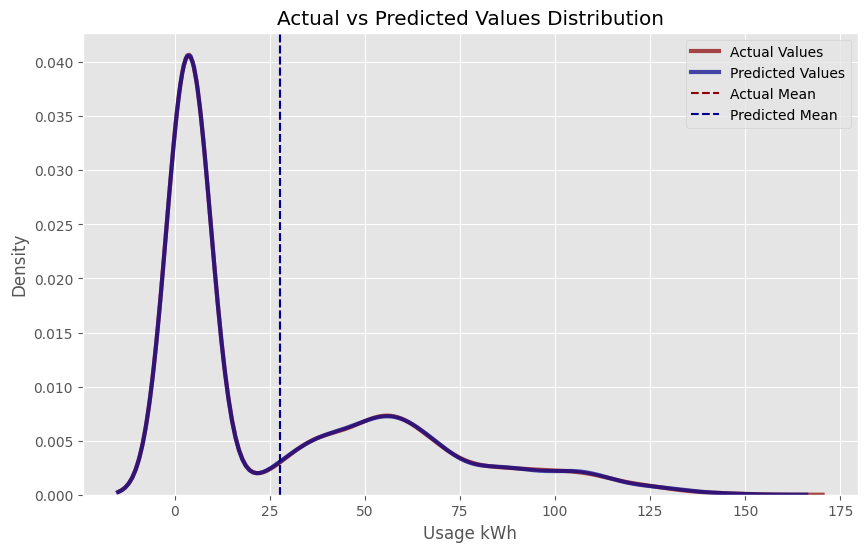

In [16]:
plt.figure(figsize=(10, 6))

# Plot the KDE for actual values
sns.kdeplot(y_test, color='darkred', label='Actual Values', alpha=0.7, lw=3)

# Plot the KDE for predicted values
sns.kdeplot(y_pred, color='darkblue', label='Predicted Values', alpha=0.7, lw=3)

# Add vertical lines for the mean of the actual and predicted values
plt.axvline(y_test.mean(), color='darkred', linestyle='--', label='Actual Mean')
plt.axvline(y_pred.mean(), color='darkblue', linestyle='--', label='Predicted Mean')

plt.title('Actual vs Predicted Values Distribution')
plt.xlabel('Usage kWh')
plt.ylabel('Density')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


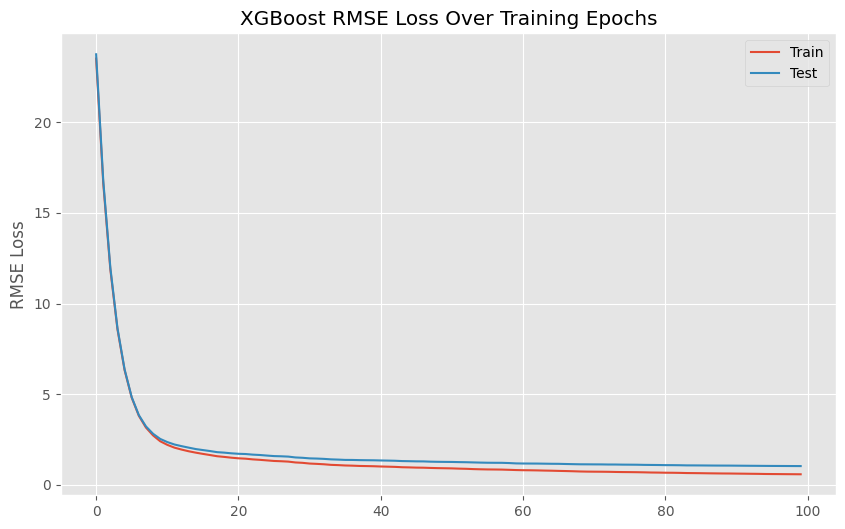

In [17]:
# Define an evaluation set
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]

# Train the model while capturing the loss for the evaluation set
xgb_regressor.fit(X_train_scaled, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)

# Retrieve performance metrics
results = xgb_regressor.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot loss curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE Loss')
plt.title('XGBoost RMSE Loss Over Training Epochs')
plt.show()


In [18]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error, median_absolute_error,
                             r2_score, explained_variance_score, mean_squared_log_error)
import numpy as np

# Ensure y_pred_optimized and y_test are defined and contain the predicted and actual values, respectively.

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Median Absolute Error
median_ae = median_absolute_error(y_test, y_pred)
print(f"Median Absolute Error: {median_ae}")

# R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2): {r2}")

# Adjusted R-squared
n = len(y_test)  # Number of observations
p = X_test.shape[1]  # Number of features (predictors)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2}")

# Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred)
print(f"Explained Variance Score: {explained_variance}")

# Mean Squared Logarithmic Error
msle = mean_squared_log_error(y_test, y_pred)
print(f"Mean Squared Logarithmic Error (MSLE): {msle}")

# Root Mean Squared Logarithmic Error
rmsle = np.sqrt(msle)
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Squared Error (MSE): 0.8093230308310971
Root Mean Squared Error (RMSE): 0.8996238274029302
Mean Absolute Error (MAE): 0.4271047135153318
Median Absolute Error: 0.13546837329864503
R-squared (R2): 0.9992880204743785
Adjusted R-squared: 0.9992859824622828
Explained Variance Score: 0.9992881341137518
Mean Squared Logarithmic Error (MSLE): 0.0012303798095556785
Root Mean Squared Logarithmic Error (RMSLE): 0.03507677022697042
Mean Absolute Percentage Error (MAPE): 2.416899756129788%


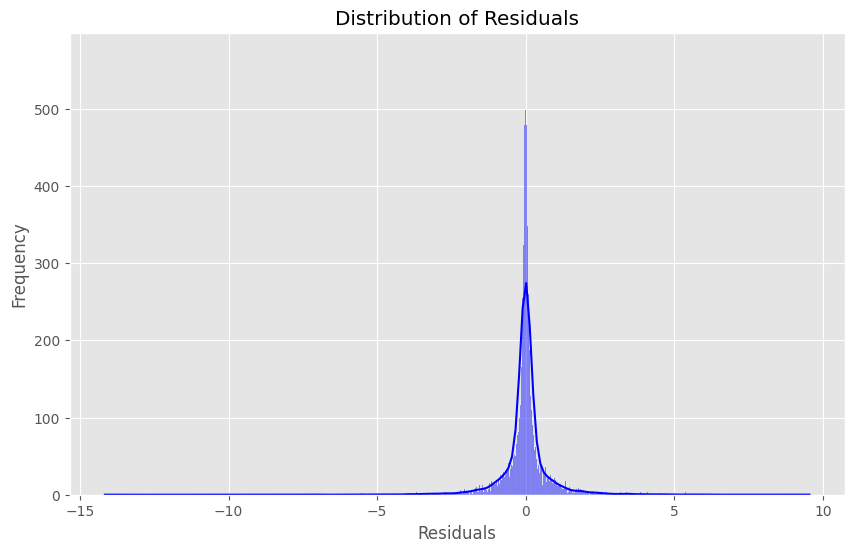

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming error metrics have been calculated and are stored in respective variables

# Visualize the distribution of errors (residuals)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

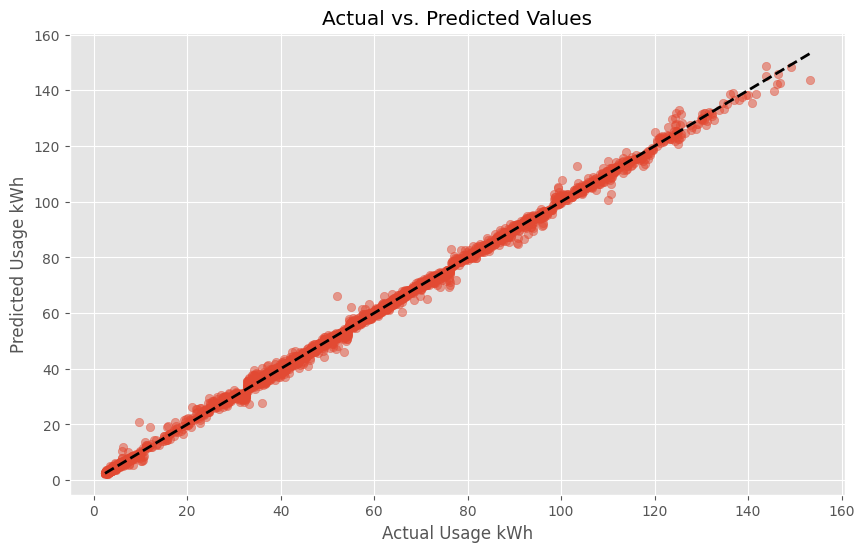

In [20]:
# Scatter plot of Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Usage kWh')
plt.ylabel('Predicted Usage kWh')
plt.show()

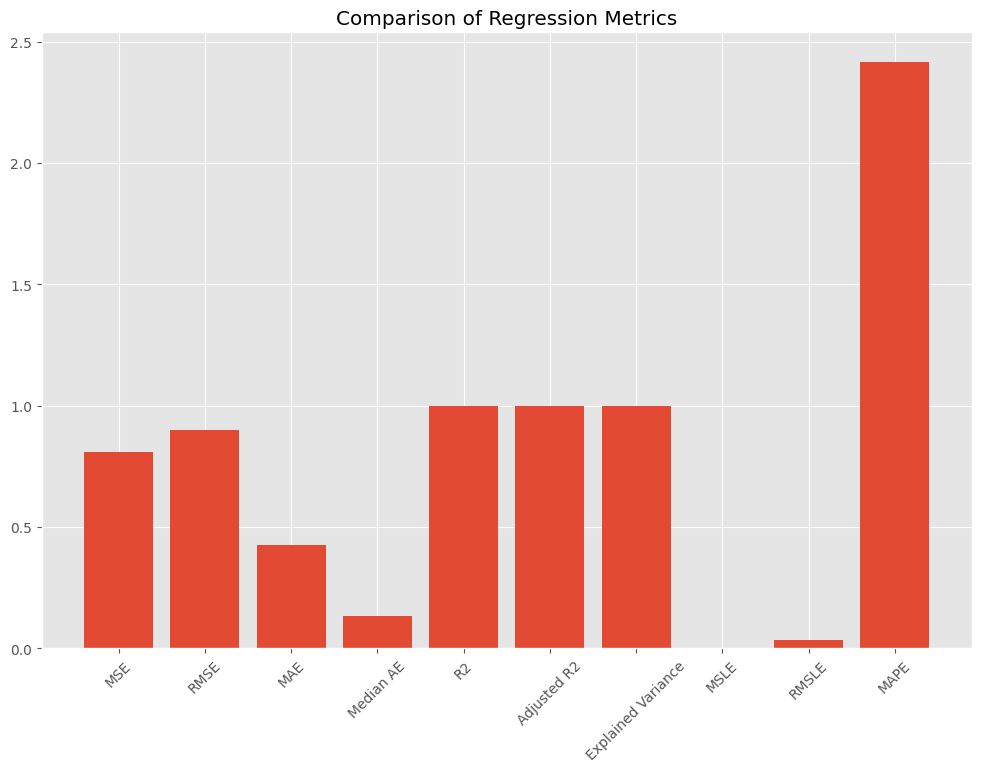

In [21]:
# Bar plot for scalar metrics
scalar_metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'Median AE': median_ae,
    'R2': r2,
    'Adjusted R2': adjusted_r2,
    'Explained Variance': explained_variance,
    'MSLE': msle,
    'RMSLE': rmsle,
    'MAPE': mape
}

plt.figure(figsize=(12, 8))
plt.bar(range(len(scalar_metrics)), list(scalar_metrics.values()), align='center')
plt.xticks(range(len(scalar_metrics)), list(scalar_metrics.keys()), rotation=45)
plt.title('Comparison of Regression Metrics')
plt.show()
